# Implémentez un modèle de scoring

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite développer un modèle de scoring de la probabilité de défaut de paiement du client pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 
Les données

Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

Votre mission

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# bokeh basics
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

pd.set_option('display.max_columns', 200) #Pour avoir accès à toutes les colonnes dans la méthode display
pd.set_option('display.max_rows', 200) #Pour avoir accès à toutes les colonnes dans la méthode display
pd.set_option('max_colwidth', 255) 

# Fonctions utiles

## DataFrame Properties

In [3]:
# ma fonction favorite
def df_properties(df):
    import time
    t = time.time()
    data = pd.DataFrame(columns = ['object','count','% count','unique'], index = df.columns) 
    
    for col in df.columns:
        data.loc[col,:]=[df[col].dtypes,df[col].count(),df[col].count()/len(df)*100,df[col].nunique()]
    print('creating df took',time.time()-t,'seconds')    

    return data

## Convert Types 

This will help reduce memory usage by using more efficient types for the variables. For example category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [4]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')

## Aggregation de variables

In [5]:
def agg_numeric(df, group_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[group_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[group_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values (duplicated columns)
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [6]:
def count_categorical(df, group_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values (duplicated columns)
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [7]:
# Function to Aggregate Stats at the Client Level

def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = count_categorical(df, group_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')
        
        gc.enable()
        del df_agg, df_counts
        gc.collect()
        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

## Figures

In [8]:
def boxplots(data, column): 
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    sns.boxplot(data = data, x='TARGET', y= column,ax=ax[0])
    ax[0].set_xticklabels(['No Default', 'Default'])

    sns.boxplot(data = data, x='TARGET', y= column,showfliers = False, ax = ax[1])
    ax[1].set_xticklabels(['No Default', 'Default'])

    plt.show()

In [9]:
# Plots the violin plot of a variable colored by value of the target 
def violin_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    sns.violinplot(y=var_name, x='TARGET', data=df, split=True, 
               scale="width", inner="quartile");
    
    # label the plot
    plt.ylabel(var_name); plt.xlabel('Target'); plt.title('%s Distribution' % var_name)
    plt.gca().set_xticklabels(['No Default', 'Default'])
    # print out the correlation
    print('The correlation between %s and the Target is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

# Schéma des données

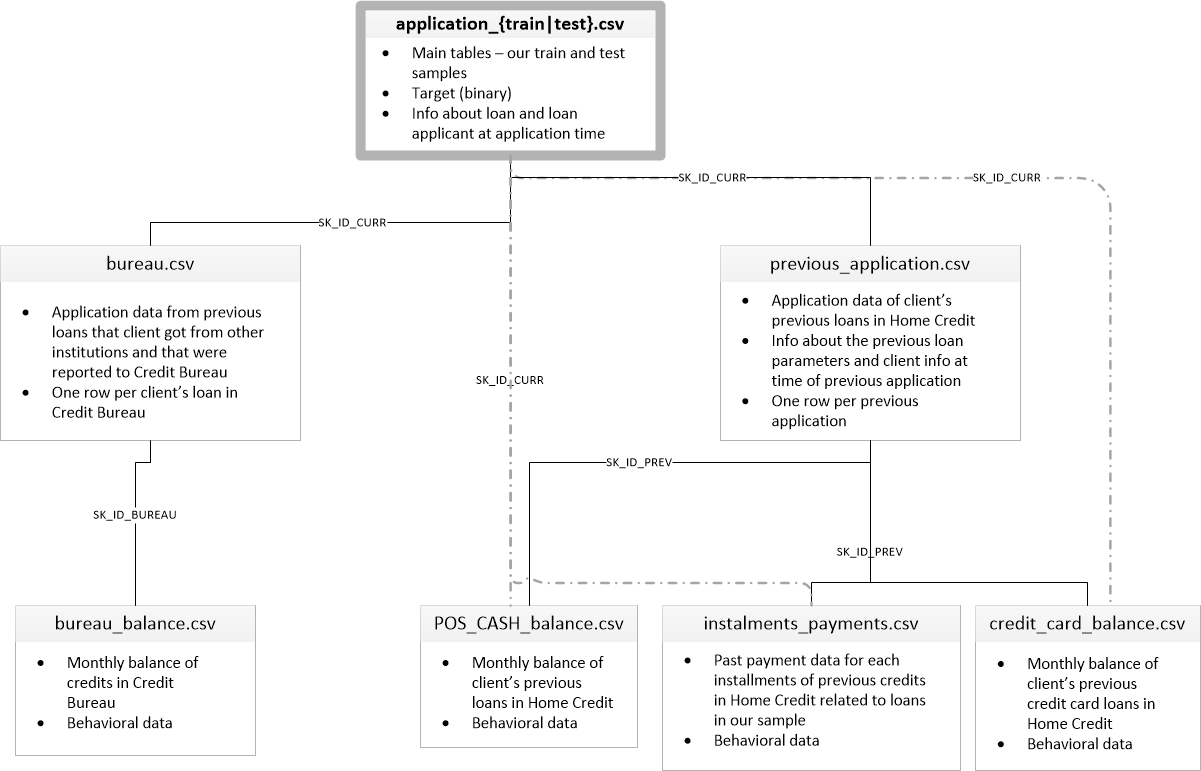

## Description des colonnes 

In [10]:
columns_description = pd.read_csv('home-credit-default-risk/HomeCredit_columns_description.csv',index_col = 0)
columns_description.sample(5)

,Table,Row,Description,Special
213,previous_application.csv,NFLAG_INSURED_ON_APPROVAL,Did the client requested insurance during the previous application,NaN
194,previous_application.csv,DAYS_DECISION,Relative to current application when was the decision about previous application made,time only relative to the application
63,application_{train|test}.csv,YEARS_BEGINEXPLUATATION_MODE,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the ...",normalized
35,application_{train|test}.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for the loan,NaN
149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN


In [11]:
columns_description.loc[columns_description.Row == 'EXT_SOURCE_3']

,Table,Row,Description,Special
46,application_{train|test}.csv,EXT_SOURCE_3,Normalized score from external data source,normalized


# APPLICATION TRAIN / TEST

In [12]:
app_test = pd.read_csv('home-credit-default-risk/application_test.csv')
app_train = pd.read_csv('home-credit-default-risk/application_train.csv')
app_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
155059,279735,0,Cash loans,F,N,Y,0,180000.0,485640.0,41674.5,450000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.018029,-10523,-695,-3803.0,-3175,NaN,1,1,0,1,0,0,NaN,1.0,3,3,SUNDAY,5,0,0,0,0,1,1,Industry: type 9,0.406647,0.568806,0.661024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,5.0,0.0,-421.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
302487,450449,1,Cash loans,F,Y,Y,0,157500.0,472500.0,22729.5,472500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-11487,-2057,-2644.0,-1221,5.0,1,1,1,1,0,0,Managers,2.0,2,2,THURSDAY,17,0,0,0,0,0,0,Trade: type 2,NaN,0.170949,0.000527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1139.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.0,0.0,0.0,2.0
202653,334922,0,Cash loans,M,N,Y,0,225000.0,1129500.0,35595.0,1129500.0,Family,Commercial associate,Higher education,Married,House / apartment,0.026392,-17767,-2208,-10324.0,-1239,NaN,1,1,0,1,0,0,Security staff,2.0,2,2,THURSDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.663462,0.699704,0.647977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-2845.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
40368,146764,0,Cash loans,F,N,N,0,67500.0,298512.0,21631.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Marr

In [13]:
convert_types(app_train, print_info = True)
convert_types(app_test, print_info = True)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.13 gb.
Original Memory Usage: 0.05 gb.
New Memory Usage: 0.02 gb.


In [14]:
table = 'application_{train|test}.csv'
df_properties(app_train).reset_index()\
        .merge(df_properties(app_test).reset_index(), on ="index", suffixes=('_train', '_test'))\
        .merge(columns_description.loc[columns_description.Table == table], 
               left_on = 'index', right_on = 'Row', how = 'left')\
        .loc[:,['Row','Description','object_train','object_test','unique_train','% count_train','unique_test','% count_test' ]]\
        .set_index('Row')

creating df took 0.785815954208374 seconds
creating df took 0.15471386909484863 seconds


,Description,object_train,object_test,unique_train,% count_train,unique_test,% count_test
Row,,,,,,,
SK_ID_CURR,ID of loan in our sample,int32,int32,307511,100.0,48744,100.0
NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,category,category,2,100.0,2,100.0
CODE_GENDER,Gender of the client,category,category,3,100.0,2,100.0
FLAG_OWN_CAR,Flag if the client owns a car,category,category,2,100.0,2,100.0
FLAG_OWN_REALTY,Flag if client owns a house or flat,category,category,2,100.0,2,100.0
CNT_CHILDREN,Number of children the client has,int32,int32,15,100.0,11,100.0
AMT_INCOME_TOTAL,Income of the client,float32,float32,2548,100.0,606,100.0
AMT_CREDIT,Credit amount of the loan,float32,float32,5603,100.0,2937,100.0
AMT_ANNUITY,Loan annuity,float32,float32,13672,99.996098,7491,99.950763


In [15]:
columns_description.loc[columns_description.Row == 'TOTALAREA_MODE','Description'].to_list()

['Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor']

- Les colonnes au suffixes "_AVG", "_MODE" et "_MEDI" sont à la fois peu claires et peu remplies : on les supprime
- Les colonnes "EXT_SOURCE_" agrègent des données externes donc il n'est pas possible d'avoir l'explicabilité : on les supprime

In [16]:
col_to_drop = app_train.columns[app_train.columns.str.contains('_MEDI|_AVG|_MODE|EXT_SOURCE_',regex = True)]
print('nb_of_cols before : ', app_train.columns.size)
app_train.drop(columns = col_to_drop, inplace = True)
app_test.drop(columns = col_to_drop, inplace = True)
print('nb_of_cols after : ', app_train.columns.size)

nb_of_cols before :  122
nb_of_cols after :  72


## One-hot/label encoding
- Label Encoding uniquement sur les colonnes avec 2 uniques valeurs
- One Hot Encoding des autres colonnes (get dummies)

In [17]:
# Create a label encoder object
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    #if app_train[col].dtype == 'category':
    if hasattr(app_train[col],'cat'):
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [18]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 181)
Testing Features shape:  (48744, 177)


- On garde dans train_app uniquement les colonnes qui existent dans test + la colonne TARGET (fonction align)

In [19]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 178)
Testing Features shape:  (48744, 177)


## Analyse de colonnes  

In [20]:
# DAYS_Birth = jours depuis la naissance. Négatif
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

The correlation between AGE and the Target is -0.0782
Median value for loan that was not repaid = 39.1288
Median value for loan that was repaid =     43.4986


5

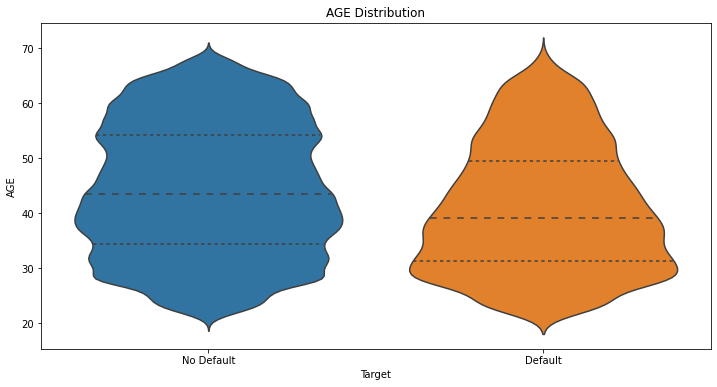

In [21]:
age_df = app_train.loc[:,['DAYS_BIRTH','TARGET']]
age_df['AGE'] = - age_df['DAYS_BIRTH']/365
violin_target("AGE",age_df)

gc.enable()
del age_df
gc.collect()


- OK 

In [22]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

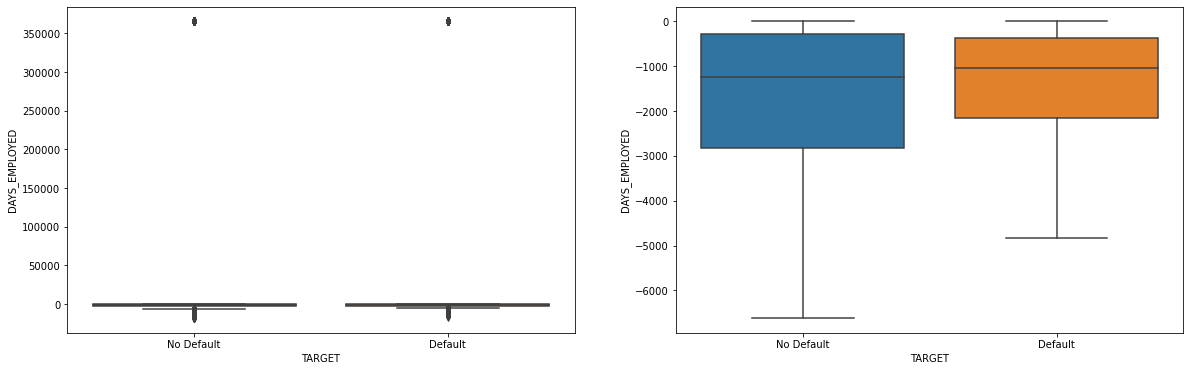

In [23]:
boxplots(app_train, 'DAYS_EMPLOYED')

In [24]:
print('nb de valeurs uniques supérieures à 0 :', 
      app_train.loc[app_train['DAYS_EMPLOYED']> 0,'DAYS_EMPLOYED'].nunique())

nb de valeurs uniques supérieures à 0 : 1


In [25]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


- Une valeur anormale : 365243
- Les clients avec une valeur anormale ont moins de défaut de paiment


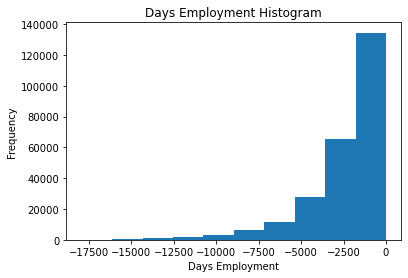

In [26]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = (app_train["DAYS_EMPLOYED"] == 365243) | (app_train["DAYS_EMPLOYED"].isna())
app_test['DAYS_EMPLOYED_ANOM'] = (app_test["DAYS_EMPLOYED"] == 365243) | (app_test["DAYS_EMPLOYED"].isna())
# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [27]:
df_properties(app_train)

creating df took 0.7472817897796631 seconds


,object,count,% count,unique
SK_ID_CURR,int32,307511,100.0,307511
NAME_CONTRACT_TYPE,int64,307511,100.0,2
FLAG_OWN_CAR,int64,307511,100.0,2
FLAG_OWN_REALTY,int64,307511,100.0,2
CNT_CHILDREN,int32,307511,100.0,15
AMT_INCOME_TOTAL,float32,307511,100.0,2548
AMT_CREDIT,float32,307511,100.0,5603
AMT_ANNUITY,float32,307499,99.996098,13672
AMT_GOODS_PRICE,float32,307233,99.909597,1002
REGION_POPULATION_RELATIVE,float32,307511,100.0,81


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar: https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features

    CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
    ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
    CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
    DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and his great script for exploring these features.

In [28]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [29]:
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']

# BUREAU

In [30]:
# Read in bureau
bureau = pd.read_csv('home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [31]:
columns_description.loc[columns_description.Table == "bureau.csv"]

,Table,Row,Description,Special
125,bureau.csv,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau",hashed
126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
129,bureau.csv,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
130,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,NaN
131,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
132,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
133,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),NaN
134,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,NaN


In [32]:
convert_types(bureau, print_info = True)
df_properties(bureau).sort_values(by=['% count'])

Original Memory Usage: 0.23 gb.
New Memory Usage: 0.1 gb.
creating df took 0.6028211116790771 seconds


,object,count,% count,unique
AMT_ANNUITY,float32,489637,28.52651,40321
AMT_CREDIT_MAX_OVERDUE,float32,591940,34.486736,68251
DAYS_ENDDATE_FACT,float32,1082775,63.083042,2917
AMT_CREDIT_SUM_LIMIT,float32,1124648,65.522585,51726
AMT_CREDIT_SUM_DEBT,float32,1458759,84.988068,226527
DAYS_CREDIT_ENDDATE,float32,1610875,93.850427,14096
AMT_CREDIT_SUM,float32,1716415,99.999243,236688
CREDIT_ACTIVE,category,1716428,100.0,4
CREDIT_CURRENCY,category,1716428,100.0,4
DAYS_CREDIT,int32,1716428,100.0,2923


## Nombre de prêts précédents

In [33]:
# Groupby the client id (SK_ID_CURR), 
#count the number of previous loans, 
#and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [34]:
# Merge to app_train
# Fill the missing values with 0 
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left').fillna(0)
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left').fillna(0)

gc.enable()
del previous_loan_counts
gc.collect()

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_T

The correlation between previous_loan_counts and the Target is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


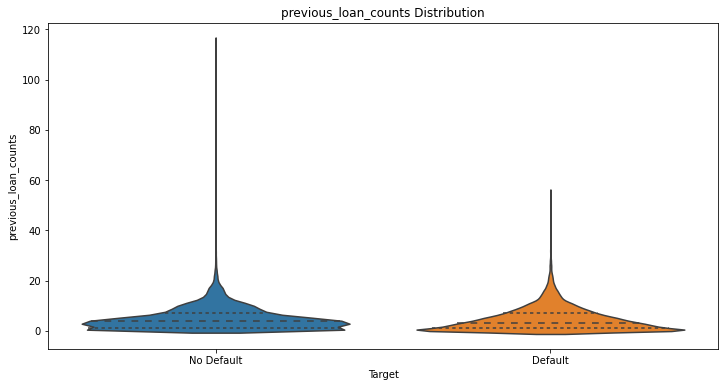

In [35]:
violin_target('previous_loan_counts',app_train)

## aggregate numeric values

In [36]:
bureau_agg = agg_numeric(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_ANNUITY_min,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_DAYS_ENDDATE_FACT_count,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_DAYS_CREDIT_ENDDATE_count,bureau_AMT_ANNUITY_count,bureau_AMT_CREDIT_SUM_count,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_CREDIT_ENDDATE_max,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-5145,-3302.0,-1572,-1329.0,-1328.0,-825.500000,-735.000000,-652,-544.0,-155,-93.142857,-49,-6,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,4,6,7,7,7,7,7,82.428574,577.0,1778.0,3545.357178,10822.5,24817.5,85240.929688,85500.0,207623.578125,373239.0,378000.000000,596686.5,1.453365e+06,NaN,NaN,NaN
100002,-6992,-4185.0,-1437,-1072.0,-1185.0,-697.500000,-874.000000,-3999,-36.0,-1185,-499.875000,-103,-7,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,5,7997.141113,8405.144531,31988.564453,31988.564453,6,4,5,6,7,8,8,-349.000000,-2094.0,780.0,0.000000,0.0,0.0,49156.199219,0.0,108131.945312,245781.0,450000.000000,245781.0,8.650556e+05,0.0,1681.029053,5043.64502
100003,-5603,-3292.0,-2586,-2434.0,-2131.0,-1097.333374,-1400.750000,-3264,-540.0,-2131,-816.000000,-606,-43,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,4,202500.000000,0.000000,810000.000000,810000.000000,3,4,4,4,0,4,4,-544.500000,-2178.0,1216.0,NaN,NaN,0.0,0.000000,22248.0,254350.125000,0.0,810000.000000,0.0,1.017400e+06,0.0,0.000000,0.00000
100004,-1734,-1065.0,-1326,-595.0,-683.0,-532.500000,-867.000000,-1064,-382.0,-682,-532.000000,-408,-382,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,NaN,1,0.000000,0.000000,0.000000,0.000000,2,2,2,2,0,2,2,-488.500000,-977.0,-382.0,NaN,NaN,0.0,0.000000,94500.0,94518.898438,0.0,94537.796875,0.0,1.890378e+05,0.0,0.000000,0.00000
100005,-572,-123.0,-373,-128.0,-123.0,-123.000000,-190.666667,-163,-123.0,-121,-54.333333,-62,-11,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000,1,3,3,3,3,3,3,439.333344,1318.0,1324.0,1420.500000,4261.5,4261.5,189469.500000,29826.0,219042.000000,543087.0,568800.000000,568408.5,6.571260e+05,0.0,0.000000,0.00000


In [37]:
# Merge with the train and test data
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
gc.enable()
del bureau_agg
gc.collect()
app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts,bureau_DAYS_CREDIT_sum,bureau_DAYS_ENDDATE_FACT_sum,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,burea

## Categorical variables

In [38]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts

,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum,bureau_CREDIT_ACTIVE_Bad debt_mean,bureau_CREDIT_ACTIVE_Bad debt_sum,bureau_CREDIT_TYPE_Interbank credit_mean,bureau_CREDIT_TYPE_Interbank credit_sum,bureau_CREDIT_TYPE_Real estate loan_mean,bureau_CREDIT_TYPE_Real estate loan_sum,bureau_CREDIT_CURRENCY_currency 4_mean,bureau_CREDIT_CURRENCY_currency 4_sum,bureau_CREDIT_CURRENCY_currency 3_mean,bureau_CREDIT_CURRENCY_currency 3_sum,bureau_CREDIT_TYPE_Loan for the purchase of equipment_mean,bureau_CREDIT_TYPE_Loan for the purchase of equipment_sum,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_mean,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_sum,bureau_CREDIT_TYPE_Unknown type of loan_mean,bureau_CREDIT_TYPE_Unknown type of loan_sum,bureau_CREDIT_TYPE_Another type of loan_mean,bureau_CREDIT_TYPE_Another type of loan_sum,bureau_CREDIT_TYPE_Loan for working capital replenishment_mean,bureau_CREDIT_TYPE_Loan for working capital replenishment_sum,bureau_CREDIT_CURRENCY_currency 2_mean,bureau_CREDIT_CURRENCY_currency 2_sum,bureau_CREDIT_ACTIVE_Sold_mean,bureau_CREDIT_ACTIVE_Sold_sum,bureau_CREDIT_TYPE_Mortgage_mean,bureau_CREDIT_TYPE_Mortgage_sum,bureau_CREDIT_TYPE_Microloan_mean,bureau_CREDIT_TYPE_Microloan_sum,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for business development_sum,bureau_CREDIT_TYPE_Credit card_mean,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_ACTIVE_Active_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.428571,0.571429,1.000000,1.0,3,4,7,7,7
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,4,0.250000,0.750000,0.500000,1.0,2,6,4,8,8
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.500000,2,0.250000,0.750000,0.500000,1.0,1,3,2,4,4
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.000000,1.000000,1.000000,1.0,0,2,2,2,2
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.333333,1,0.666667,0.333333,0.666667,1.0,2,1,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.076923,1,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.230769,3,0.153846,0.846154,0.692308,1.0,2,11,9,13,13
456250,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.333333,1,0.666667,0.333333,0.666667,1.0,2,1,2,3,3
456253,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.250000,1,0.500000,0.500000,0.750000,1.0,2,2,3,4,4


## Merge to train/test

In [39]:
# Merge with the train and test data
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del bureau_counts
gc.collect()

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_UPDATE_sum,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_UPDATE_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CREDIT_DAY_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_sum,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_ANNUITY_min,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_DAYS_ENDDATE_FACT_count,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_DAYS_CREDIT_ENDDATE_count,bureau_AMT_ANNUITY_count,bureau_AMT_CREDIT_SUM_count,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_CREDIT_ENDDATE_max,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_sum,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_CREDIT_TYPE_Mobile operator loan_mean,bureau_CREDIT_TYPE_Mobile operator loan_sum,b

# BUREAU BALANCE
## Chargement

In [40]:
# Read in bureau balance
bureau_balance = pd.read_csv('home-credit-default-risk/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [41]:
columns_description.loc[columns_description.Table == "bureau_balance.csv"]

,Table,Row,Description,Special
142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique coding for each application) - use this to join to CREDIT_BUREAU table,hashed
143,bureau_balance.csv,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
144,bureau_balance.csv,STATUS,"Status of Credit Bureau loan during the month (active, closed, DPD0-30,� [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,� 5 means DPD 120+ or sold or written off ] )",NaN


In [42]:
convert_types(bureau_balance, print_info = True)
df_properties(bureau_balance).sort_values(by=['% count'])

Original Memory Usage: 0.66 gb.
New Memory Usage: 0.25 gb.
creating df took 1.5140581130981445 seconds


,object,count,% count,unique
SK_ID_BUREAU,int32,27299925,100.0,817395
MONTHS_BALANCE,int32,27299925,100.0,97
STATUS,category,27299925,100.0,8


## Aggregate by bureau

In [43]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_X_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_0_count
SK_ID_BUREAU,,,,,,,,,,,,,,,,,
5001709,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97
5001710,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83
5001711,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4
5001712,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.526316,10,0.000000,0.473684,0,9,19
5001713,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,1.000000,0.000000,22,0,22


In [44]:
# Calculate value count statistics for each `SK_ID_BUREAU` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count
SK_ID_BUREAU,,,,,
5001709,-4656,-96,-48.0,0,97
5001710,-3403,-82,-41.0,0,83
5001711,-6,-3,-1.5,0,4
5001712,-171,-18,-9.0,0,19
5001713,-231,-21,-10.5,0,22


## Group by loan / client

In [45]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

gc.enable()
del bureau_balance_counts,bureau_balance_agg,bureau_balance
gc.collect()

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_count,bureau_balance_STATUS_4_mean,bureau_balance_STATUS_3_mean,bureau_balance_STATUS_2_mean,bureau_balance_STATUS_5_mean,bureau_balance_STATUS_4_sum,bureau_balance_STATUS_3_sum,bureau_balance_STATUS_2_sum,bureau_balance_STATUS_5_sum,bureau_balance_STATUS_1_mean,bureau_balance_STATUS_1_sum,bureau_balance_STATUS_0_mean,bureau_balance_STATUS_0_sum,bureau_balance_STATUS_X_mean,bureau_balance_STATUS_C_mean,bureau_balance_STATUS_X_sum,bureau_balance_STATUS_C_sum,bureau_balance_STATUS_0_count,SK_ID_CURR
0,5001709,-4656,-96,-48.0,0,97,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,0.113402,0.886598,11,86,97,NaN
1,5001710,-3403,-82,-41.0,0,83,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.060241,5,0.361446,0.578313,30,48,83,162368.0
2,5001711,-6,-3,-1.5,0,4,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.750000,3,0.250000,0.000000,1,0,4,162368.0
3,5001712,-171,-18,-9.0,0,19,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.526316,10,0.000000,0.473684,0,9,19,162368.0
4,5001713,-231,-21,-10.5,0,22,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.000000,0,1.000000,0.000000,22,0,22,150635.0


In [46]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_STATUS_5_mean_min,client_bureau_balance_STATUS_5_sum_min,client_bureau_balance_STATUS_4_mean_min,client_bureau_balance_STATUS_4_sum_min,client_bureau_balance_STATUS_3_mean_min,client_bureau_balance_STATUS_3_sum_min,client_bureau_balance_STATUS_4_mean_mean,client_bureau_balance_STATUS_5_mean_mean,client_bureau_balance_STATUS_4_mean_max,client_bureau_balance_STATUS_4_mean_sum,client_bureau_balance_STATUS_5_mean_max,client_bureau_balance_STATUS_5_mean_sum,client_bureau_balance_STATUS_4_sum_mean,client_bureau_balance_STATUS_5_sum_mean,client_bureau_balance_STATUS_4_sum_max,client_bureau_balance_STATUS_4_sum_sum,client_bureau_balance_STATUS_5_sum_max,client_bureau_balance_STATUS_5_sum_sum,client_bureau_balance_STATUS_2_mean_min,client_bureau_balance_STATUS_2_sum_min,client_bureau_balance_STATUS_3_mean_mean,client_bureau_balance_STATUS_3_mean_max,client_bureau_balance_STATUS_3_mean_sum,client_bureau_balance_STATUS_3_sum_mean,client_bureau_balance_STATUS_3_sum_max,client_bureau_balance_STATUS_3_sum_sum,client_bureau_balance_STATUS_1_mean_min,client_bureau_balance_STATUS_1_sum_min,client_bureau_balance_STATUS_2_mean_mean,client_bureau_balance_STATUS_2_mean_max,client_bureau_balance_STATUS_2_mean_sum,client_bureau_balance_STATUS_2_sum_mean,client_bureau_balance_STATUS_2_sum_max,client_bureau_balance_STATUS_2_sum_sum,client_bureau_balance_STATUS_X_mean_min,client_bureau_balance_STATUS_X_sum_min,client_bureau_balance_STATUS_C_mean_min,client_bureau_balance_STATUS_C_sum_min,client_bureau_balance_STATUS_1_mean_mean,client_bureau_balance_STATUS_0_mean_min,client_bureau_balance_STATUS_1_mean_max,client_bureau_balance_STATUS_1_mean_sum,client_bureau_balance_STATUS_1_sum_mean,client_bureau_balance_STATUS_X_mean_mean,client_bureau_balance_STATUS_0_mean_mean,client_bureau_balance_STATUS_C_mean_mean,client_bureau_balance_STATUS_X_mean_max,client_bureau_balance_STATUS_C_mean_max,client_bureau_balance_STATUS_0_mean_max,client_bureau_balance_STATUS_0_sum_min,client_bureau_balance_STATUS_1_sum_max,client_bureau_balance_STATUS_1_sum_sum,client_bureau_balance_STATUS_X_mean_sum,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_STATUS_0_mean_sum,client_bureau_balance_STATUS_C_mean_sum,client_bureau_balance_STATUS_X_sum_mean,client_bureau_balance_STATUS_0_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_STATUS_X_sum_max,client_bureau_balance_STATUS_0_sum_max,client_bureau_balance_STATUS_C_sum_mean,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_STATUS_X_sum_sum,client_bureau_balance_STATUS_0_sum_sum,client_bureau_balance_STATUS_C_sum_max,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_STATUS_C_sum_sum,client_bureau_balance_MONTHS_BALANCE_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-400.000000,-165,-82.5,-51,-25.5,-23.571429,-11.785714,-1,-1,-0.5,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.000000,0,0.007519,0.019231,0.052632,0.052632,0.142857,0.214590,0.336651,0.441240,0.500000,0.966667,1.000000,1,1,1,1.502129,2,2.356557,3.088683,4.285714,4.428571,7,9,12,15.714286,

## Merge to train / test

In [47]:
# merge to app_train and app_test
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del bureau_balance_by_client
gc.collect()

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,bureau_CREDIT_TYPE_Car loan_mean,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for business development_sum,bureau_CREDIT_TYPE_Credit card_mean,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_ACTIVE_Active_count,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_STATUS_5_mean_min,client_bureau_balance_STATUS_5_sum_min,client_bureau_balance_STATUS_4_mean_min,client_bureau_balance_STATUS_4_sum_min,client_bureau_balance_STATUS_3_mean_min,client_bureau_balance_STATUS_3_sum_min,client_bureau_balance_STATUS_4_mean_mean,client_bureau_balance_STATUS_5_mean_mean,client_bureau_balance_STATUS_4_mean_max,client_bureau_balance_STATUS_4_mea

# PREVIOUS
## Chargement

In [48]:
previous = pd.read_csv('home-credit-default-risk/previous_application.csv')
convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.16 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,True,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,True,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
columns_description.loc[columns_description.Table == "previous_application.csv"]

,Table,Row,Description,Special
176,previous_application.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)",hashed
177,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
178,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application",NaN
179,previous_application.csv,AMT_ANNUITY,Annuity of previous application,NaN
180,previous_application.csv,AMT_APPLICATION,For how much credit did client ask on the previous application,NaN
181,previous_application.csv,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AM...",NaN
182,previous_application.csv,AMT_DOWN_PAYMENT,Down payment on the previous application,NaN
183,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application,NaN
184,previous_application.csv,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application,NaN
185,previous_application.csv,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application,rounded


In [50]:
df_properties(previous).sort_values(by=['% count'])

creating df took 1.292121171951294 seconds


,object,count,% count,unique
RATE_INTEREST_PRIVILEGED,float32,5951,0.356302,25
RATE_INTEREST_PRIMARY,float32,5951,0.356302,148
RATE_DOWN_PAYMENT,float32,774370,46.36352,191301
AMT_DOWN_PAYMENT,float32,774370,46.36352,29278
NAME_TYPE_SUITE,category,849809,50.880246,7
NFLAG_INSURED_ON_APPROVAL,float32,997149,59.701871,2
DAYS_FIRST_DRAWING,float32,997149,59.701871,2838
DAYS_FIRST_DUE,float32,997149,59.701871,2892
DAYS_LAST_DUE_1ST_VERSION,float32,997149,59.701871,4605
DAYS_LAST_DUE,float32,997149,59.701871,2873


## Nombre de prêts précédents

In [51]:
# Groupby the client id (SK_ID_CURR), 
#count the number of previous loans, 
#and rename the column
previous_loan_counts = previous.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'home_credit_previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,home_credit_previous_loan_counts
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [52]:
# Merge to app_train
# Fill the missing values with 0 
app_train = app_train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left').fillna(0)
app_test = app_test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left').fillna(0)

gc.enable()
del previous_loan_counts
gc.collect()

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,bureau_CREDIT_TYPE_Car loan_sum,bureau_CREDIT_TYPE_Loan for business development_mean,bureau_CREDIT_TYPE_Loan for business development_sum,bureau_CREDIT_TYPE_Credit card_mean,bureau_CREDIT_TYPE_Credit card_sum,bureau_CREDIT_ACTIVE_Active_mean,bureau_CREDIT_ACTIVE_Closed_mean,bureau_CREDIT_TYPE_Consumer credit_mean,bureau_CREDIT_CURRENCY_currency 1_mean,bureau_CREDIT_ACTIVE_Active_sum,bureau_CREDIT_ACTIVE_Closed_sum,bureau_CREDIT_TYPE_Consumer credit_sum,bureau_CREDIT_CURRENCY_currency 1_sum,bureau_CREDIT_ACTIVE_Active_count,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_STATUS_5_mean_min,client_bureau_balance_STATUS_5_sum_min,client_bureau_balance_STATUS_4_mean_min,client_bureau_balance_STATUS_4_sum_min,client_bureau_balance_STATUS_3_mean_min,client_bureau_balance_STATUS_3_sum_min,client_bureau_balance_STATUS_4_mean_mean,client_bureau_balance_STATUS_5_mean_mean,client_bureau_balance_STATUS_4_mean_max,client_bureau_balance_STATUS_4_mean_sum,client_bureau_balance_STATU

## Aggregate data by client

In [53]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 80)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,previous_DAYS_LAST_DUE_mean,previous_DAYS_LAST_DUE_max,previous_DAYS_TERMINATION_sum,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_LAST_DUE_1ST_VERSION_sum,previous_DAYS_LAST_DUE_1ST_VERSION_min,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_max,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_sum,previous_RATE_INTEREST_PRIMARY_count,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_sum,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_sum,previous_AMT_DOWN_PAYMENT_count,previous_DAYS_FIRST_DRAWING_count,previous_AMT_GOODS_PRICE_count,previous_AMT_ANNUITY_count,previous_CNT_PAYMENT_count,previous_AMT_CREDIT_count,previous_AMT_APPLICATION_count,previous_CNT_PAYMENT_min,previous_CNT_PAYMENT_mean,previous_CNT_PAYMENT_max,previous_CNT_PAYMENT_sum,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_sum,previous_SELLERPLACE_AREA_min,previous_SELLERPLACE_AREA_mean,previous_SELLERPLACE_AREA_max,previous_SELLERPLACE_AREA_sum,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_sum,previous_AMT_CREDIT_min,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_sum,previous_AMT_APPLICATION_min,previous_AMT_GOODS_PRICE_min,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_AMT_APPLICATION_max,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_sum,previous_AMT_APPLICATION_sum,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,-1619.000000,-1619.0,-1612.0,-1612.0,-1612.000000,-1612.0,-1499.0,-1499.0,-1499.000000,-1499.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.104326,0.104326,0.104326,0.104326,1,1,1,1,1,1,1,8.0,8.0,8.0,8.0,13,13.000000,13,13,23,23.0,23,23,2520.0,2520.0,2520.0,2520.0,3951.000000,3951.000000,3951.000000,3951.000000,23787.0,23787.00,23787.0,23787.0,24835.5,24835.5,24835.50,24835.5,24835.5,24835.5,24835.5,24835.5,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,-25.000000,-25.0,-17.0,-17.0,-17.000000,-17.0,125.0,125.0,125.000000,125.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1,1,1,24.0,24.0,24.0,24.0,9,9.000000,9,9,500,500.0,500,500,0.0,0.0,0.0,0.0,9251.775391,9251.775391,9251.775391,9251.775391,179055.0,179055.00,179055.0,179055.0,179055.0,179055.0,179055.00,179055.0,179055.0,179055.0,179055.0,179055.0,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,-1054.333374,-536.0,-3142.0,-1976.0,-1047.333374,-527.0,-3013.0,-1980.0,-1004.333313,-386.0,0.0,0.0,0,0.0,0.666667,1.0,2.0,0.000000,0.050030,0.100061,0.100061,2,3,3,3,3,3,3,6.0,10.0,12.0,30.0,12,14.666667,17,44,-1,533.0,1400,1599,0.0,3442.5,6885.0,6885.0,6737.310059,56553.988281

In [54]:
previous_counts = count_categorical(previous, group_var = 'SK_ID_CURR', df_name = 'previous')
previous_counts.head()

,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Education_sum,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_GOODS_CATEGORY_Additional Service_sum,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_sum,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_GOODS_CATEGORY_Insurance_sum,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_sum,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_GOODS_CATEGORY_Fitness_sum,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_sum,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_sum,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_sum,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_sum,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_sum,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_sum,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_NAME_GOODS_CATEGORY_Weapon_sum,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_CODE_REJECT_REASON_SYSTEM_sum,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CONTRACT_TYPE_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_sum,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_GOODS_CATEGORY_Medicine_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_sum,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_sum,previous_CHANNEL_TYPE_Car dealer_mean,previous_NAME_PORTFOLIO_Cars_mean,previous_CHANNEL_TYPE_Car dealer_sum,previous_NAME_PORTFOLIO_Cars_sum,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_sum,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_TYPE_SUITE_Group of people_sum,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_sum,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_sum,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_sum,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_SELLER_INDUSTRY_Tourism_sum,previous_NAME_GOODS_CATEGORY_Tourism_sum,previous_CODE_REJECT_REASON_XNA_sum,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_sum,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_sum,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_GOODS_CATEGORY_Jewelry_sum,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_sum,previous_NAME_GOODS_CATEGORY_Other_mean,previous_

## Merge to train and test

In [55]:
# Merge with the train and test data
app_train = app_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_counts, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del previous_agg,previous_counts, previous
gc.collect()

app_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,previous_NAME_CONTRACT_TYPE_Revolving loans_sum,previous_PRODUCT_COMBINATION_Cash_mean,previous_NAME_CONTRACT_STATUS_Canceled_mean,previous_NAME_PORTFOLIO_XNA_mean,previous_NAME_YIELD_GROUP_XNA_mean,previous_WEEKDAY_APPR_PROCESS_START_THURSDAY_mean,previous_PRODUCT_COMBINATION_Cash_sum,previous_NAME_CONTRACT_STATUS_Canceled_sum,previous_NAME_PORTFOLIO_XNA_sum,previous_NAME_YIELD_GROUP_XNA_sum,previous_WEEKDAY_APPR_PROCESS_START_THURSDAY_sum,previous_PRODUCT_COMBINATION_POS mobile without interest_mean,previous_PRODUCT_COMBINATION_POS mobile without interest_sum,previous_CHANNEL_TYPE_Regional / Local_mean,previous_CHANNEL_TYPE_Regional / Local_sum,previous_NAME_GOODS_CATEGORY_Furniture_mean,previous_NAME_SELLER_INDUSTRY_Furniture_mean,previous_NAME_GOODS_CATEGORY_Consumer Electronics_mean,previous_PRODUCT_COMBINATION_POS industry with interest_mean,previous_PRODUCT_COMBINATION_POS household with interest_mean,previous_WEEKDAY_APPR_PROCESS_START_SUNDAY_mean,previous_NAME_SELLER_INDUSTRY_Consumer electronics_mean,previous_PRODUCT_COMBINATION_Cash X-Sell: low_mean,previous_NAME_PORTFOLIO_Cash_mean,previous_NAME_PRODUCT_TYPE_x-sell_mean,previous_NAME_CASH_LOAN_PURPOSE_XNA_mean,previous_NAME_CONTRACT_TYPE_Cash loans_mean,previous_CHANNEL_TYPE_Credit and cash offices_mean,previous_NAME_SELLER_INDUSTRY_XNA_mean,previous_NAME_GOODS_CATEGORY_XNA_mean,previous_NAME_CLIENT_TYPE_Repeater_mean,previous_NAME_TYPE_SUITE_Unaccompanied_mean,previous_NAME_YIELD_GROUP_middle_mean,previous_NAME_GOODS_CATEGORY_Furniture_sum,previous_NAME_SELLER_INDUSTRY_Furniture_sum,previous_NAME_GOODS_CATEGORY_Consumer Electronics_sum,previous_PRODUCT_COMBINATION_POS industry with interest_su

# CASH
## Chargement

In [56]:
# Read in cash balance
cash = pd.read_csv('home-credit-default-risk/POS_CASH_balance.csv')
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [57]:
columns_description.loc[columns_description.Table == "POS_CASH_balance.csv"]

,Table,Row,Description,Special
145,POS_CASH_balance.csv,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",NaN
146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
147,POS_CASH_balance.csv,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )",time only relative to the application
148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previous credit,NaN
152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit,NaN


In [58]:
convert_types(cash, print_info = True)
df_properties(cash)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.
creating df took 1.3329927921295166 seconds


,object,count,% count,unique
SK_ID_PREV,int32,10001358,100.0,936325
SK_ID_CURR,int32,10001358,100.0,337252
MONTHS_BALANCE,int32,10001358,100.0,96
CNT_INSTALMENT,float32,9975287,99.739325,73
CNT_INSTALMENT_FUTURE,float32,9975271,99.739165,79
NAME_CONTRACT_STATUS,category,10001358,100.0,9
SK_DPD,int32,10001358,100.0,3400
SK_DPD_DEF,int32,10001358,100.0,2307


## Group by client

In [59]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,client_cash_MONTHS_BALANCE_min_mean,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_max_mean,client_cash_MONTHS_BALANCE_min_max,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_max_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_min,client_cash_SK_DPD_DEF_min_min,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_min,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_min,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_min,client_cash_NAME_CONTRACT_STATUS_XNA_mean_mean,client_cash_NAME_CONTRACT_STATUS_XNA_mean_max,client_cash_NAME_CONTRACT_STATUS_XNA_sum_mean,client_cash_NAME_CONTRACT_STATUS_XNA_sum_max,client_cash_NAME_CONTRACT_STATUS_XNA_mean_sum,client_cash_NAME_CONTRACT_STATUS_XNA_sum_sum,client_cash_SK_DPD_min_min,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_mean,client_cash_NAME_CONTRACT_STATUS_Canceled_mean_sum,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_max,client_cash_NAME_CONTRACT_STATUS_Canceled_sum_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_max,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_mean,client_cash_NAME_CONTRACT_STATUS_Amortized debt_mean_sum,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_max,client_cash_NAME_CONTRACT_STATUS_Amortized debt_sum_sum,client_cash_NAME_CONTRACT_STATUS_Demand_mean_min,client_cash_NAME_CONTRACT_STATUS_Demand_mean_mean,client_cash_NAME_CONTRACT_STATUS_Demand_mean_max,client_cash_NAME_CONTRACT_STATUS_Demand_sum_min,client_cash_NAME_CONTRACT_STATUS_Demand_sum_mean,client_cash_NAME_CONTRACT_STATUS_Demand_mean_sum,client_cash_NAME_CONTRACT_STATUS_Demand_sum_max,client_cash_NAME_CONTRACT_STATUS_Demand_sum_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_min,client_cash_NAME_CONTRACT_STATUS_Approved_sum_min,client_cash_SK_DPD_min_mean,client_cash_SK_DPD_min_max,client_cash_SK_DPD_min_sum,client_cash_NAME_CONTRACT_STATUS_Approved_mean_mean,client_cash_NAME_CONTRACT_STATUS_Approved_mean_max,client_cash_NAME_CONTRACT_STATUS_Approved_sum_mean,client_cash_NAME_CONTRACT_STATUS_Approved_sum_max,client_cash_NAME_CONTRACT_STATUS_Approved_mean_sum,client_cash_NAME_CONTRACT_STATUS_Approved_sum_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_min,client_cash_SK_DPD_DEF_mean_min,client_cash_SK_DPD_mean_min,client_cash_SK_DPD_DEF_max_min,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_max_min,client_cash_SK_DPD_sum_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_sum,client_cash_NAME_CONTRACT_STATUS_Signed_mean_min,client_cash_NAME_CONTRACT_STATUS_Signed_mean_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_min,client_cash_NAME_CONTRACT_STATUS_Signed_sum_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_sum,client_cash_NAME_CONTRACT_STATUS_Signed_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_min_min,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_CNT_I

## Merge to train and test 

In [60]:
print('Cash by Client Shape: ', cash_by_client.shape)
app_train = app_train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

print(app_train.shape)
app_train.head()

Cash by Client Shape:  (337252, 165)
(307511, 903)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,client_cash_SK_DPD_DEF_mean_min,client_cash_SK_DPD_mean_min,client_cash_SK_DPD_DEF_max_min,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_max_min,client_cash_SK_DPD_sum_min,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_mean,client_cash_NAME_CONTRACT_STATUS_Returned to the store_mean_sum,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_max,client_cash_NAME_CONTRACT_STATUS_Returned to the store_sum_sum,client_cash_NAME_CONTRACT_STATUS_Signed_mean_min,client_cash_NAME_CONTRACT_STATUS_Signed_mean_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_min,client_cash_NAME_CONTRACT_STATUS_Signed_sum_mean,client_cash_NAME_CONTRACT_STATUS_Signed_sum_max,client_cash_NAME_CONTRACT_STATUS_Signed_mean_sum,client_cash_NAME_CONTRACT_STATUS_Signed_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_min_min,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_NAME_CONTRACT_STATUS_Completed_mean_min,client_cash_NAME_CONTRACT_STATUS_Completed_mean_mean,client_cash_NAME_CONTRACT_STATUS_Completed_mean_max,client_cash_NAME_CONTRACT_STATUS_Active_mean_min,client_cash_CNT_INSTALMENT_FUTURE_mean_min,client_cash_SK_DPD_DEF_mean_mean,client_cash_SK_DPD_mean_mean,client_cash_NAME_CONTRACT_STATUS_Active_mean_mean,client_cash_NAME_CONTRACT_STATUS_Active_mean_max,client_cash_NAME_CONTRACT_STATUS_Completed_sum_min,client_cash_NAME_CONTRACT_STATUS_Completed_sum_mean,client_cash_NAME_CONTRACT_STATUS_Completed_sum_max,cl

# MONTHLY CREDIT DATA
## Chargement

In [61]:
# Read in credit data
credit = pd.read_csv('home-credit-default-risk/credit_card_balance.csv')
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [62]:
columns_description.loc[columns_description.Table == "credit_card_balance.csv"]

,Table,Row,Description,Special
153,credit_card_balance.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
154,credit_card_balance.csv,SK_ID_CURR,ID of loan in our sample,hashed
155,credit_card_balance.csv,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date),time only relative to the application
156,credit_card_balance.csv,AMT_BALANCE,Balance during the month of previous credit,NaN
157,credit_card_balance.csv,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit,NaN
158,credit_card_balance.csv,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit,NaN
159,credit_card_balance.csv,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit,NaN
160,credit_card_balance.csv,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit,NaN
161,credit_card_balance.csv,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit,NaN
162,credit_card_balance.csv,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit,NaN


In [63]:
convert_types(credit, print_info = True)
df_properties(credit)

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.34 gb.
creating df took 1.9614100456237793 seconds


,object,count,% count,unique
SK_ID_PREV,int32,3840312,100.0,104307
SK_ID_CURR,int32,3840312,100.0,103558
MONTHS_BALANCE,int32,3840312,100.0,96
AMT_BALANCE,float32,3840312,100.0,1347882
AMT_CREDIT_LIMIT_ACTUAL,int32,3840312,100.0,181
AMT_DRAWINGS_ATM_CURRENT,float32,3090496,80.475128,2267
AMT_DRAWINGS_CURRENT,float32,3840312,100.0,187005
AMT_DRAWINGS_OTHER_CURRENT,float32,3090496,80.475128,1832
AMT_DRAWINGS_POS_CURRENT,float32,3090496,80.475128,168748
AMT_INST_MIN_REGULARITY,float32,3535076,92.051792,312266


## Group by client

In [64]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,client_credit_MONTHS_BALANCE_mean_min,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_max_mean,client_credit_AMT_RECIVABLE_min_sum,client_credit_AMT_TOTAL_RECEIVABLE_min_sum,client_credit_AMT_RECIVABLE_min_min,client_credit_AMT_TOTAL_RECEIVABLE_min_min,client_credit_AMT_RECIVABLE_min_mean,client_credit_AMT_TOTAL_RECEIVABLE_min_mean,client_credit_AMT_RECIVABLE_min_max,client_credit_AMT_TOTAL_RECEIVABLE_min_max,client_credit_SK_DPD_min_mean,client_credit_SK_DPD_min_sum,client_credit_CNT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_min,client_credit_NAME_CONTRACT_STATUS_Demand_sum_min,client_credit_NAME_CONTRACT_STATUS_Approved_mean_max,client_credit_NAME_CONTRACT_STATUS_Approved_mean_mean,client_credit_NAME_CONTRACT_STATUS_Approved_sum_mean,client_credit_NAME_CONTRACT_STATUS_Approved_mean_sum,client_credit_NAME_CONTRACT_STATUS_Approved_sum_sum,client_credit_NAME_CONTRACT_STATUS_Demand_mean_mean,client_credit_NAME_CONTRACT_STATUS_Demand_mean_max,client_credit_NAME_CONTRACT_STATUS_Demand_sum_mean,client_credit_NAME_CONTRACT_STATUS_Demand_sum_max,client_credit_NAME_CONTRACT_STATUS_Demand_mean_sum,client_credit_NAME_CONTRACT_STATUS_Demand_sum_sum,client_credit_NAME_CONTRACT_STATUS_Refused_mean_max,client_credit_NAME_CONTRACT_STATUS_Refused_mean_mean,client_credit_NAME_CONTRACT_STATUS_Refused_sum_mean,client_credit_NAME_CONTRACT_STATUS_Refused_mean_sum,client_credit_NAME_CONTRACT_STATUS_Refused_sum_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_max,client_credit_NAME_CONTRACT_STATUS_Sent proposal_mean_sum,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_min,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_mean,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_max,client_credit_NAME_CONTRACT_STATUS_Sent proposal_sum_sum,client_credit_CNT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_POS_CURRENT_min_sum,client_credit_AMT_INST_MIN_REGULARITY_min_min,client_credit_AMT_INST_MIN_REGULARITY_min_mean,client_credit_AMT_INST_MIN_REGULARITY_min_max,client_credit_AMT_INST_MIN_REGULARITY_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_min,client_credit_CNT_DRAWINGS_CURRENT_min_mean,client_credit_CNT_DRAWINGS_CURRENT_min_max,client_credit_CNT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_CNT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_min,client_credit_AMT_DRAWINGS_CURRENT_min_mean,client_credit_AMT_DRAWINGS_CURRENT_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_min,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_mean,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_min_sum,client_credit_AMT_DRAWINGS_CURRENT_min_sum,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_min,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_mean,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_max,client_credit_AMT_PAYMENT_TOTAL_CURRENT_min_sum,client_credit_AMT_BALANCE_min_min,client_credit_AMT_BALANCE_min_mean,client_credit_AMT_BALANCE_min_max,client_credit_AMT_RECEIVABLE_PRINCIPAL_min_sum,client_credit_AMT_BALANCE_min_sum,client_credit_AMT_PAYMENT_CURRENT_min_sum,client_credit_NAME_CONTRACT_STATUS_Signed_mean_min,client_credit_NAME_CONTRACT_STATUS_Signed_mean_max,client_credit_NAME_CONTRACT_STATUS_Signed_mean_mean,client_credit_NAME_CONTRACT_STATUS_Signed_sum_min,client_credit_NAME_CONTRACT_STATUS_Signed_sum_mean,client_credit_NAME_CONTRACT_STATUS_Signed_sum_max,client_credit_NAME_C

## Merge to train and test

In [65]:
print('Credit by client shape: ', credit_by_client.shape)

app_train = app_train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

print(app_train.shape)
app_train.head()

Credit by client shape:  (103558, 381)
(307511, 1284)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,client_credit_AMT_RECEIVABLE_PRINCIPAL_sum_sum,client_credit_AMT_RECIVABLE_sum_sum,client_credit_AMT_TOTAL_RECEIVABLE_sum_sum,client_credit_AMT_BALANCE_sum_sum,client_credit_NAME_CONTRACT_STATUS_Active_mean_min,client_credit_NAME_CONTRACT_STATUS_Active_mean_max,client_credit_NAME_CONTRACT_STATUS_Active_mean_mean,client_credit_AMT_INST_MIN_REGULARITY_count_min,client_credit_AMT_INST_MIN_REGULARITY_count_mean,client_credit_AMT_INST_MIN_REGULARITY_count_max,client_credit_NAME_CONTRACT_STATUS_Active_sum_min,client_credit_NAME_CONTRACT_STATUS_Active_sum_mean,client_credit_NAME_CONTRACT_STATUS_Active_sum_max,client_credit_NAME_CONTRACT_STATUS_Active_mean_sum,client_credit_NAME_CONTRACT_STATUS_Active_count_min,client_credit_NAME_CONTRACT_STATUS_Active_count_mean,client_credit_NAME_CONTRACT_STATUS_Active_count_max,client_credit_NAME_CONTRACT_STATUS_Approved_mean_count,client_credit_AMT_INST_MIN_REGULARITY_count_sum,client_credit_NAME_CONTRACT_STATUS_Active_sum_sum,client_credit_NAME_CONTRACT_STATUS_Active_count_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_max_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_min_sum,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_min,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_mean,client_credit_AMT_CREDIT_LIMIT_ACTUAL_sum_max,client_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_sum,client_cr

# INSTALLMENTS PAYMENTS
## Chargement

In [66]:
# Read in installments payments 
installments = pd.read_csv('home-credit-default-risk/installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [67]:
columns_description.loc[columns_description.Table == "installments_payments.csv"]

,Table,Row,Description,Special
214,installments_payments.csv,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)",hashed
215,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed
216,installments_payments.csv,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed,NaN
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,NaN
221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous credit on this installment,NaN


In [68]:
convert_types(installments, print_info = True)
df_properties(installments)

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.44 gb.
creating df took 2.7043251991271973 seconds


,object,count,% count,unique
SK_ID_PREV,int32,13605401,100.0,997752
SK_ID_CURR,int32,13605401,100.0,339587
NUM_INSTALMENT_VERSION,float32,13605401,100.0,65
NUM_INSTALMENT_NUMBER,int32,13605401,100.0,277
DAYS_INSTALMENT,float32,13605401,100.0,2922
DAYS_ENTRY_PAYMENT,float32,13602496,99.978648,3039
AMT_INSTALMENT,float32,13605401,100.0,902522
AMT_PAYMENT,float32,13602496,99.978648,944214


## Group by client

In [69]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,client_installments_NUM_INSTALMENT_NUMBER_min_max,client_installments_NUM_INSTALMENT_VERSION_max_max,client_installments_NUM_INSTALMENT_NUMBER_mean_min,client_installments_NUM_INSTALMENT_NUMBER_mean_mean,client_installments_NUM_INSTALMENT_NUMBER_mean_max,client_installments_DAYS_ENTRY_PAYMENT_count_min,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_sum_min,client_installments_DAYS_ENTRY_PAYMENT_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_NUMBER_max_min,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_NUM_INSTALMENT_NUMBER_max_max,client_installments_DAYS_ENTRY_PAYMENT_count_max,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_sum_mean,client_installments_NUM_INSTALMENT_VERSION_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_count,client_installments_DAYS_ENTRY_PAYMENT_sum_count,client_installments_NUM_INSTALMENT_VERSION_min_sum,client_installments_NUM_INSTALMENT_VERSION_mean_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_min,client_installments_NUM_INSTALMENT_NUMBER_sum_mean,client_installments_NUM_INSTALMENT_NUMBER_min_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_max,client_installments_NUM_INSTALMENT_VERSION_max_sum,client_installments_NUM_INSTALMENT_NUMBER_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_count_sum,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_NUMBER_max_sum,client_installments_NUM_INSTALMENT_VERSION_sum_sum,client_installments_NUM_INSTALMENT_NUMBER_sum_sum,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_INSTALMENT_min_min,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_INSTALMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_INSTALMENT_min_max,client_installments_AMT_PAYMENT_mean_min,client_installments_AMT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_max_min,client_i

## Merge to train and test

In [70]:
print('Installments by client shape: ', installments_by_client.shape)

app_train = app_train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
app_test = app_test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

print(app_train.shape)
app_train.head()

Installments by client shape:  (339587, 106)
(307511, 1390)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,...,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_mean,client_installments_NUM_

# Feature Selection
## Missing values

In [71]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [72]:
app_train, app_test = remove_missing_columns(app_train, app_test)

There are 6 columns with greater than 90% missing values.


In [73]:
print('Training Shape: ', app_train.shape)
print('Testing Shape: ', app_test.shape)

Training Shape:  (307511, 1384)
Testing Shape:  (48744, 1383)


In [74]:
for c in app_train.columns:
    print(c)

SK_ID_CURR
NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
FLAG_DOCUMENT_2
FLAG_DOCUMENT_3
FLAG_DOCUMENT_4
FLAG_DOCUMENT_5
FLAG_DOCUMENT_6
FLAG_DOCUMENT_7
FLAG_DOCUMENT_8
FLAG_DOCUMENT_9
FLAG_DOCUMENT_10
FLAG_DOCUMENT_11
FLAG_DOCUMENT_12
FLAG_DOCUMENT_13
FLAG_DOCUMENT_14
FLAG_DOCUMENT_15
FLAG_DOCUMENT_16
FLAG_DOCUMENT_17
FLAG_DOCUMENT_18
FLAG_DOCUMENT_19
FLAG_DOCUMENT_20
FLAG_DOCUMENT_

## Correlations
- On supprime les colonnes corrélées à plus de 90% deux à deux
- Calculer les correlations sur l'ensemble des données est compliqué : nous réduisons notre dataset à quelques occurences

In [75]:
app_train.set_index('SK_ID_CURR', inplace = True)
app_test.set_index('SK_ID_CURR', inplace = True)

In [76]:
sample = app_train.sample(1000)

In [77]:
print("repartition of targets without sampling : \n", 
      app_train['TARGET'].value_counts()/app_train['TARGET'].shape)
print("repartition of targets with sampling : \n", 
      sample['TARGET'].value_counts()/sample['TARGET'].shape)

repartition of targets without sampling : 
 False    0.919271
True     0.080729
Name: TARGET, dtype: float64
repartition of targets with sampling : 
 False    0.913
True     0.087
Name: TARGET, dtype: float64


In [78]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = sample.corr().abs()
corr_matrix.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,...,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_me

In [79]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,...,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_mean,client_installments_DAYS_INSTALMENT_sum_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,client_installments_DAYS_INSTALMENT_sum_max,client_installments_DAYS_ENTRY_PAYMENT_min_min,client_installments_DAYS_INSTALMENT_min_min,client_installments_DAYS_INSTALMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_mean_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_DAYS_INSTALMENT_max_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,client_installments_DAYS_INSTALMENT_min_mean,client_installments_DAYS_ENTRY_PAYMENT_mean_mean,client_installments_DAYS_INSTALMENT_mean_mean,client_installments_DAYS_ENTRY_PAYMENT_max_mean,client_installments_DAYS_INSTALMENT_max_mean,client_installments_DAYS_ENTRY_PAYMENT_min_max,client_installments_DAYS_INSTALMENT_min_max,client_installments_DAYS_ENTRY_PAYMENT_mean_max,client_installments_DAYS_INSTALMENT_mean_max,client_installments_DAYS_ENTRY_PAYMENT_max_max,client_installments_DAYS_INSTALMENT_max_max,client_installments_NUM_INSTALMENT_VERSION_min_min,client_installments_NUM_INSTALMENT_NUMBER_min_min,client_installments_NUM_INSTALMENT_VERSION_min_mean,client_installments_NUM_INSTALMENT_VERSION_min_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,client_installments_NUM_INSTALMENT_VERSION_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_NUMBER_min_me

In [80]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 593 columns to remove.


In [81]:
app_train = app_train.drop(columns = to_drop)
app_test = app_test.drop(columns = to_drop)

print('Training shape: ', app_train.shape)
print('Testing shape: ', app_test.shape)


import re
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Training shape:  (307511, 790)
Testing shape:  (48744, 789)


## Selection by feature importance

In [82]:
import lightgbm as lgb

from sklearn.model_selection import train_test_split

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [83]:
train = app_train.drop(columns = 'TARGET')
target = app_train['TARGET']

In [84]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [85]:
first_round_zero_features, feature_importances = identify_zero_importance_features(train, target)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.756895	valid_0's binary_logloss: 0.529031
Early stopping, best iteration is:
[164]	valid_0's auc: 0.75736	valid_0's binary_logloss: 0.538358
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.760371	valid_0's binary_logloss: 0.528033
Early stopping, best iteration is:
[131]	valid_0's auc: 0.761111	valid_0's binary_logloss: 0.546318

There are 278 features with 0.0 importance


In [86]:
feature_importances.head()

,feature,importance
171,CREDIT_TERM,160.5
8,DAYS_BIRTH,90.0
9,DAYS_EMPLOYED,77.0
784,client_installments_AMT_PAYMENT_min_sum,74.5
6,AMT_ANNUITY,69.5


In [87]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

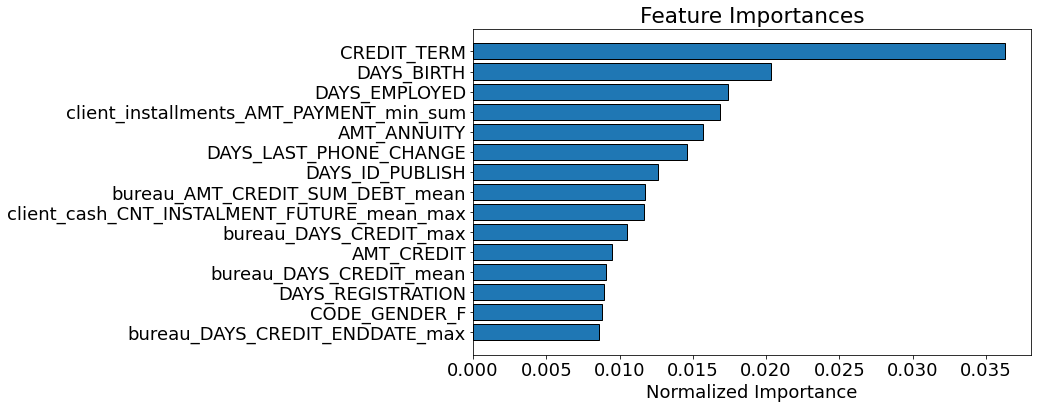

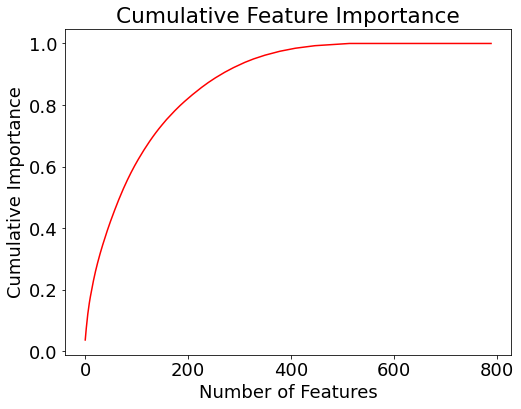

266 features required for 0.90 of cumulative importance


In [88]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [89]:
print('Training shape before removal of cols with zero importance: ', train.shape)
train = train.drop(columns = first_round_zero_features)
print('Training shape: ', train.shape)

Training shape before removal of cols with zero importance:  (307511, 789)
Training shape:  (307511, 511)


In [90]:
second_round_zero_features, feature_importances_2 = identify_zero_importance_features(train, target)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.757471	valid_0's binary_logloss: 0.528386
Early stopping, best iteration is:
[179]	valid_0's auc: 0.757766	valid_0's binary_logloss: 0.53365
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.760478	valid_0's binary_logloss: 0.527854
Early stopping, best iteration is:
[131]	valid_0's auc: 0.761111	valid_0's binary_logloss: 0.546318

There are 0 features with 0.0 importance


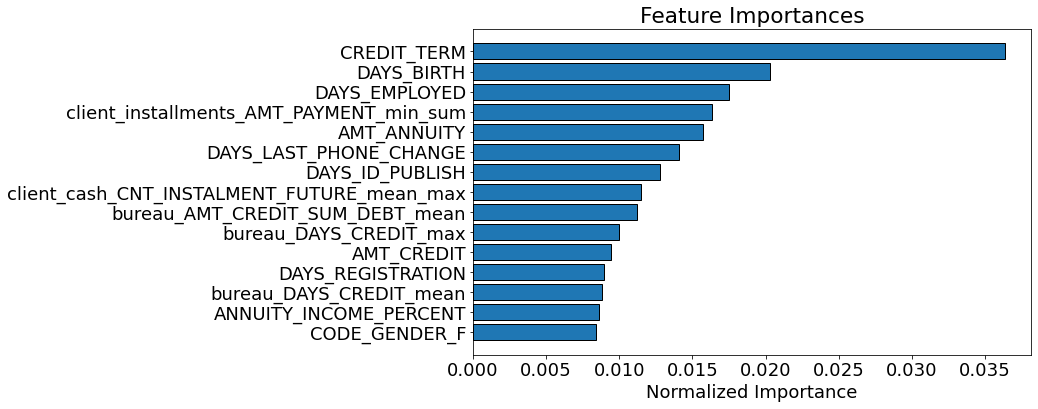

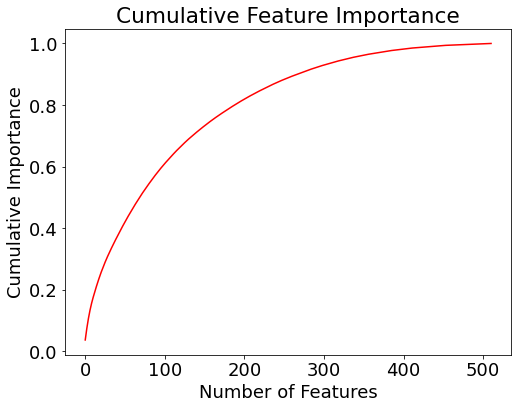

268 features required for 0.90 of cumulative importance


In [91]:
norm_feature_importances_2 = plot_feature_importances(feature_importances_2)

In [92]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

In [93]:
len(features_to_keep)

328

# Sauvegarde des tables test et train allegées 

- On garde une table de 350 variables pour nos modèles

In [94]:
train = app_train.loc[:,features_to_keep]
test = app_test.loc[:,features_to_keep]
train['TARGET'] = target

In [98]:
test

,CREDIT_TERM,DAYS_BIRTH,DAYS_EMPLOYED,client_installments_AMT_PAYMENT_min_sum,AMT_ANNUITY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,bureau_AMT_CREDIT_SUM_DEBT_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_max,bureau_DAYS_CREDIT_max,AMT_CREDIT,bureau_DAYS_CREDIT_mean,DAYS_REGISTRATION,CODE_GENDER_F,bureau_DAYS_CREDIT_ENDDATE_max,ANNUITY_INCOME_PERCENT,REGION_RATING_CLIENT,client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_min,REGION_POPULATION_RELATIVE,previous_HOUR_APPR_PROCESS_START_mean,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_MAX_OVERDUE_mean,client_cash_CNT_INSTALMENT_FUTURE_mean_mean,previous_CNT_PAYMENT_mean,previous_NAME_CONTRACT_STATUS_Refused_mean,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_mean,NAME_EDUCATION_TYPE_Highereducation,client_cash_CNT_INSTALMENT_FUTURE_min_max,CREDIT_INCOME_PERCENT,bureau_CREDIT_ACTIVE_Active_sum,previous_DAYS_DECISION_max,NAME_FAMILY_STATUS_Married,client_cash_SK_DPD_DEF_mean_mean,client_credit_CNT_DRAWINGS_CURRENT_max_min,client_installments_NUM_INSTALMENT_VERSION_mean_mean,OWN_CAR_AGE,bureau_AMT_CREDIT_MAX_OVERDUE_sum,previous_NAME_YIELD_GROUP_high_mean,previous_AMT_ANNUITY_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,previous_AMT_DOWN_PAYMENT_max,client_installments_AMT_PAYMENT_sum_mean,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_max,previous_NAME_YIELD_GROUP_low_action_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,bureau_CREDIT_TYPE_Mortgage_mean,client_installments_DAYS_ENTRY_PAYMENT_sum_max,previous_DAYS_FIRST_DUE_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_min,NAME_CONTRACT_TYPE,bureau_DAYS_CREDIT_UPDATE_max,client_installments_AMT_PAYMENT_min_max,previous_PRODUCT_COMBINATION_CashXSelllow_mean,bureau_AMT_CREDIT_SUM_sum,previous_SELLERPLACE_AREA_mean,previous_AMT_ANNUITY_min,previous_RATE_DOWN_PAYMENT_max,client_installments_AMT_INSTALMENT_max_max,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_CREDIT_ENDDATE_mean,previous_NAME_TYPE_SUITE_Unaccompanied_mean,previous_RATE_DOWN_PAYMENT_sum,client_installments_AMT_PAYMENT_sum_sum,client_cash_MONTHS_BALANCE_sum_min,client_installments_DAYS_ENTRY_PAYMENT_min_mean,bureau_DAYS_CREDIT_ENDDATE_sum,previous_DAYS_DECISION_mean,previous_CNT_PAYMENT_max,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_cash_CNT_INSTALMENT_FUTURE_mean_min,FLAG_DOCUMENT_3,previous_NAME_CONTRACT_STATUS_Approved_mean,previous_RATE_DOWN_PAYMENT_mean,client_installments_AMT_PAYMENT_mean_mean,client_installments_AMT_INSTALMENT_min_sum,FLAG_OWN_CAR,bureau_AMT_CREDIT_SUM_LIMIT_sum,client_installments_AMT_PAYMENT_sum_max,previous_SELLERPLACE_AREA_sum,client_installments_AMT_INSTALMENT_max_min,client_cash_MONTHS_BALANCE_min_mean,client_bureau_balance_STATUS_0_sum_mean,HOUR_APPR_PROCESS_START,client_cash_NAME_CONTRACT_STATUS_Active_sum_mean,AMT_INCOME_TOTAL,bureau_CREDIT_TYPE_Microloan_mean,previous_SELLERPLACE_AREA_max,client_installments_AMT_PAYMENT_sum_min,previous_DAYS_LAST_DUE_sum,client_installments_AMT_PAYMENT_mean_min,client_installments_AMT_INSTALMENT_min_min,client_installments_AMT_PAYMENT_mean_max,previous_DAYS_LAST_DUE_max,previous_NAME_YIELD_GROUP_low_normal_mean,client_installments_AMT_INSTALMENT_max_sum,previous_PRODUCT_COMBINATION_CashXSellhigh_mean,previous_AMT_CREDIT_mean,...,previous_CHANNEL_TYPE_Stone_mean,bureau_AMT_CREDIT_SUM_DEBT_min,previous_NAME_TYPE_SUITE_Spousepartner_mean,client_credit_AMT_PAYMENT_TOTAL_CURRENT_max_sum,previous_NAME_CASH_LOAN_PURPOSE_XNA_mean,previous_NAME_CONTRACT_STATUS_Canceled_mean,previous_CHANNEL_TYPE_APCashloan_mean,OBS_30_CNT_SOCIAL_CIRCLE,client_cash_NAME_CONTRACT_STATUS_Active_mean_min,previous_NAME_TYPE_SUITE_Family_mean,NAME_INCOME_TYPE_Stateservant,previous_PRODUCT_COMBINATION_POSindustrywithoutinterest_mean,previous_DAYS_FIRST_DRAWING_count,client_bureau_balance_STATUS_0_sum_max,client_credit_AMT_RECIVABLE_min_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_sum,previous_NAME_SELLER_INDUSTRY_Connectivity_mean,previous_NAME_GOODS_CATEGORY_ConsumerElectronics_m

In [99]:
# Save train table
train.to_csv('m_train.csv', index = True)
test.to_csv('m_test.csv', index = True)

# BAC A SABLE

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=0)

#print("séparation target columns")
#X = app_train.drop(columns = 'TARGET')
#y = app_train['TARGET']
#X_resampled, y_resampled = rus.fit_resample(X, y)

#print(sorted(Counter(y_resampled).items()))

# Visualisation de certaines colonnes

## Correlations 

In [ ]:
columns = bureau_agg.columns

# List of new correlations
new_corrs = []


# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = app_train['TARGET'].corr(app_train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))


# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

In [ ]:
violin_target('bureau_DAYS_CREDIT_mean', app_train)

### Corrélations

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))



Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.


###  Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])



As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.


In [ ]:
#plt.style.use('fivethirtyeight')

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, 
            label = 'No Default')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, 
            label = 'Default')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend();

### % de défauts par catégories d'age

In [ ]:
# Age information into a separate dataframe
age_data = app_train.loc[:,['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()


# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Pairs Plot

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, height = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# MODELS 

## Logistic Regression

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

## Light GBM

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics


In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)


In [ ]:
fi_sorted = plot_feature_importances(fi)

# Quelques graphs

In [ ]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100

In [ ]:
data

In [ ]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str)
values = data['index'].unique()

from bokeh.io import output_file, show
from bokeh.models import PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool


p = figure(x_range=values, plot_height=200, title="Target Counts", tools=[HoverTool()],
    tooltips="number of contracts : @TARGET (@percent{0.2f} %)",
           toolbar_location=None)

p.vbar(x="index", top="TARGET", width=0.6, source=data)

p.xgrid.grid_line_color = None
p.y_range.start = 0

p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")
#p.toolbar.autohide = False

# Set to output the plot in the notebook
output_notebook()

show(p)

In [ ]:
data = pd.DataFrame(application_train.TARGET.value_counts()).reset_index()
data['percent'] = data['TARGET']/sum(data['TARGET'])*100
data['index'] = data['index'].astype(str)

values = data['index'].unique()

from bokeh.io import output_file, show
from bokeh.models import PrintfTickFormatter
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.models import ColumnDataSource

p = figure(x_range=values, plot_height=200, title="Target Counts", tools=[HoverTool()],
    tooltips="number of contracts : @TARGET (@percent{0.2f} %)")#,toolbar_location=None)

bars = p.vbar(x="index", top="TARGET", width=0.6, source=data)

# set up textarea (div)
div = Div(
    text="""
          <p>Select the bars' width using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up spinner
spinner = Spinner(
    title="bar width",
    low=0,
    high=1,
    step=0.1,
    value=bars.glyph.width,
    width=200,
)
spinner.js_link("value", bars.glyph, "width")

p.xgrid.grid_line_color = None
p.y_range.start = 0

p.yaxis[0].formatter = PrintfTickFormatter(format="%6.0f")
#p.toolbar.autohide = False

# create layout
layout = layout(
    [
        [div, spinner],
        [p],
    ]
)

# show result
show(layout)

# Exemples Bokeh

In [ ]:
from bokeh.layouts import layout
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [4, 5, 5, 7, 2, 6, 4, 9, 1, 3]

# create plot with circle glyphs
p = figure(x_range=(1, 9), plot_width=500, plot_height=250)
points = p.circle(x=x, y=y, size=30, fill_color="#21a7df")

# set up textarea (div)
div = Div(
    text="""
          <p>Select the circle's size using this control element:</p>
          """,
    width=200,
    height=30,
)

# set up spinner
spinner = Spinner(
    title="Circle size",
    low=0,
    high=60,
    step=5,
    value=points.glyph.size,
    width=200,
)
spinner.js_link("value", points.glyph, "size")

# set up RangeSlider
range_slider = RangeSlider(
    title="Adjust x-axis range",
    start=0,
    end=10,
    step=1,
    value=(p.x_range.start, p.x_range.end),
)
range_slider.js_link("value", p.x_range, "start", attr_selector=0)
range_slider.js_link("value", p.x_range, "end", attr_selector=1)

# create layout
layout = layout(
    [
        [div, spinner],
        [range_slider],
        [p],
    ]
)

# show result
show(layout)

In [ ]:
fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
counts = [5, 3, 4, 2, 4, 6]

source = ColumnDataSource(data=dict(fruits=fruits, counts=counts, color=Spectral6))

p = figure(x_range=fruits, y_range=(0,9), plot_height=250, title="Fruit counts",
           toolbar_location=None, tools="")

p.vbar(x='fruits', top='counts', width=0.9, color='color', legend_field="fruits", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

output_notebook()
show(p)

In [ ]:


# Create a blank figure with labels
p = figure(plot_width = 600, plot_height = 600, 
           title = 'Example Glyphs',
           x_axis_label = 'X', y_axis_label = 'Y')

# Example data
squares_x = [1, 3, 4, 5, 8]
squares_y = [8, 7, 3, 1, 10]
circles_x = [9, 12, 4, 3, 15]
circles_y = [8, 4, 11, 6, 10]

# Add squares glyph
p.square(squares_x, squares_y, size = 12, color = 'navy', alpha = 0.6)
# Add circle glyph
p.circle(circles_x, circles_y, size = 12, color = 'red')

# Set to output the plot in the notebook
output_notebook()
# Show the plot
show(p)